# SETUP

The first part of the code sets up the pca_wavelet network, the training comes later. Most of this code comes from the original authors

In [1]:
import sys
sys.path.append('../segmentation_helper')

import tensorflow as tf
import keras
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import data_loader as dl
import model_broker as mb
import os

GPU device not found
Found GPU at: 


In [2]:
tf.keras.backend.set_floatx("float64")

In [3]:
dataset = "pets"
test_size=300
loader = dl.DataLoader(IMAGE_SIZE=512,dataset=dataset)
img_ds = loader.import_processed_img()
seg_ds = loader.import_processed_seg()
cardinality = int(img_ds.cardinality())

img_test = img_ds.take(test_size)
seg_test = seg_ds.take(test_size)
img_train = img_ds.skip(test_size)
seg_train = seg_ds.skip(test_size)    

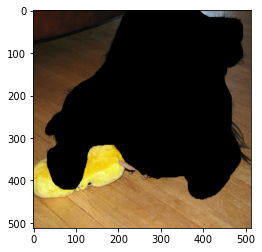

In [4]:
plt.imshow((next(iter(seg_train))[0]))

In [5]:
def scaledtanh(x): 
    return tf.math.tanh(x*0.5)

def scaledatanh(x):
    return tf.math.atanh(x)*2.0

In [6]:
model_name = "img"
img_broker = mb.ModelBroker(trainset=img_train,
                            testset=img_test,
                            dirname=dataset+"_"+model_name,
                            keep_percent=0.6,
                            count=7,
                            sample_size=100,)
                            #activity_regularizer = scaledtanh,
                            #inverse_activity_regularizer=scaledatanh)

imghead,imginvhead = img_broker.build_model()
imghead,imginvhead = img_broker.load_model()    

keep_percent 0.41316621666612496
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 256.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 11 keep_max 12.0
keep_channels 11
ufilts.shape (1, 1, 1, 27, 11)
end loop 256.0
Starting level 1


C:\Users\spurl\AppData\Local\Temp\__autograph_generated_filec0_v_d0f.py:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt((ag__.ld(self).data_format is 'channels_first'), if_body, else_body, get_state, set_state, ('pad',), 1)
C:\Users\spurl\AppData\Local\Temp\__autograph_generated_filec0_v_d0f.py:42: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt((ag__.ld(self).data_format is 'channels_last'), if_body_1, else_body_1, get_state_1, set_state_1, ('pad',), 1)


Completing 128.0
pca shape tf.Tensor([99 99], shape=(2,), dtype=int32)
keep_channels 40 keep_max 176.0
keep_channels 40
ufilts.shape (1, 1, 1, 99, 40)
end loop 128.0
Starting level 2


KeyboardInterrupt: 

In [ ]:
model_name = "seg"
seg_broker = mb.ModelBroker(trainset=seg_train,
                            testset=seg_test,
                            dirname=dataset+"_"+model_name,
                            keep_percent=0.6,
                            count=7,
                            sample_size=100,)
                            #activity_regularizer = scaledtanh,
                            #inverse_activity_regularizer=scaledatanh)

seghead,seginvhead = seg_broker.build_model()
seghead,seginvhead = seg_broker.load_model()    

In [ ]:
seg_broker.check_build(seghead,seginvhead,seg_test)

In [ ]:
img_broker.check_build(imghead,imginvhead,img_test)

# Training

This is the loop used to find the variables to find A and b in y=Ax+b

In [ ]:
imgflat = np.prod(imghead(next(iter(img_train))[0]).shape)
segflat = np.prod(seghead(next(iter(seg_train))[0]).shape)
end_shape = next(iter(seg_train))[0].shape
n = 0.0

xxt = np.zeros([imgflat])
yxt = np.zeros([segflat])
x = np.zeros([imgflat])
y = np.zeros([segflat]) 

bar = tqdm.notebook.tqdm(total = int(img_train.cardinality()))

for item in iter(zip(img_train,seg_train)):

    bar.update(1)

    image = item[0][0]
    segmentation = item[1][0]

    imgdecom = imghead(image)
    segdecom = seghead(segmentation)

    mat = tf.reshape(imgdecom,[-1])
    segmat = tf.reshape(segdecom,[-1])

    cov = tf.matmul([mat],[mat],transpose_a=True)
    xxt += cov
    segcov = tf.matmul([mat],[segmat],transpose_a=True)
    yxt += segcov
    x+=mat
    y+=segmat
    n += 1

## Calculating A and B

This section uses the values found in the training loop to calculate values for A and B

In [ ]:
xxt = xxt - tf.matmul([x],[x],transpose_a=True)/n
yxt = yxt - tf.matmul([x],[y],transpose_a=True)/n

In [ ]:
inverse_xxt = tf.linalg.pinv(xxt)

In [ ]:
A = tf.linalg.matmul(inverse_xxt,yxt)

In [ ]:
b = (y - tf.linalg.matvec(A,x,transpose_a=True))/n

In [ ]:
def dice_coef(y_true, y_pred,smooth=1):
    y_true_f = tf.reshape(y_true,-1)
    y_pred_f =tf.reshape(y_pred,-1)
    intersection = tf.reduce_sum(y_true_f * y_pred_f,0)

    return float((2. * intersection+smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)+smooth))

In [ ]:
def iou_coef(y_true, y_pred,smooth=1):
  intersection = tf.reduce_sum(y_true * y_pred, 0)
  union = tf.reduce_sum(y_true,0)+tf.reduce_sum(y_pred,0)-intersection
  iou = tf.reduce_mean((intersection+1) / (union+1), 0)
  return float(iou)

In [ ]:
import random
reconstruct = seghead(next(iter(seg_train))[0]).shape
skip = random.randint(0,10)
image,seg_base = next(iter(zip(img_test.skip(skip),seg_test.skip(skip))))
imgdecom = imghead(image[0])
imgdecom = tf.reshape(imgdecom,(1,-1))
segdecom = tf.linalg.matvec(A,imgdecom,transpose_a=True)+b
seg = seginvhead(tf.reshape(segdecom,(reconstruct)))
threshold_intensity = tf.reduce_min(seg[0])*0.5
y_true = tf.cast(tf.reduce_min(seg_base[0],2)==0,tf.float64)
y_pred = tf.cast(tf.reduce_min(seg[0],2)<=threshold_intensity,tf.float64)
plt.subplot(2,1,1)
plt.imshow(np.hstack([image[0],seg_base[0],seg[0]]))
plt.subplot(2,1,2)
plt.imshow(np.hstack([y_true,y_pred]))
print(dice_coef(y_true,y_pred))

In [ ]:
dice_coeff_vals = []
n = int(seg_train.cardinality())
for image,seg_base in iter(zip(img_test.skip(skip),seg_test.skip(skip))):
    imgdecom = imghead(image[0])
    imgdecom = tf.reshape(imgdecom,(1,-1))
    segdecom = tf.linalg.matvec(A,imgdecom,transpose_a=True)+b
    seg = seginvhead(tf.reshape(segdecom,(reconstruct)))
    threshold_intensity = tf.reduce_min(seg[0])*0.5
    y_true = tf.cast(tf.reduce_min(seg_base[0],2)==0,tf.float64)
    y_pred = tf.cast(tf.reduce_min(seg[0],2)<=threshold_intensity,tf.float64)
    dice_coeff_vals.append(dice_coef(y_true,y_pred))
dice_coeff_mean = sum(dice_coeff_vals)/n
dice_coeff_std = (sum([((x - dice_coeff_mean) ** 2) for x in dice_coeff_vals]) / n)**0.5